# Perceptron from scratch

Perceptron is the simplest form of artificial neural network used for binary classifcation. In this notebook we'll implement one from scratch. This can help us understand the foundations of neural network.

```
make a super naive network like this:

x1---w1
       \
x2---w2--weighted sum--activation function-->y
       /
1----w3(bias)
```

where we calculate a weighted sum of the input and then use a step function to determine y like so: y = 1 if sum > 0 else 0. The input has a bias term from 1*w3 to provide flexibility. Without the bias term, f([0,0]) will always be 0 regardless of the weights, which might not be desired.

## Problem to be solved

Create an artificial data set where we want to predict the binary classification

In [67]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

x_samples = np.random.randint(0, 10, size=(50, 2))
y_samples = np.random.randint(0, 2, size=50)

df = pd.DataFrame(x_samples)
df.columns = ['x1', 'x2']
df['y'] = y_samples
df.head()

,x1,x2,y
0,5,9,1
1,1,7,1
2,6,8,1
3,8,5,1
4,4,9,1


## Implement a naive perceptron

weighted sum is simply $\Sigma_{i} x_i w_i$, the dot product of input x and weight vector w. When taking an array of inputs, we can use marix multiplication to generate weighted sums for all samples.

In [170]:
class NaivePerceptron:
    def __init__(self):
        self.w = np.random.randn(3)

    def activate(self, weighted_sum):
        return 1 if weighted_sum > 0 else 0

    def weighted_sum(self, x):
        with_bias = np.c_[x, np.ones((x.shape[0]))]
        return np.matmul(with_bias, self.w.transpose())

    def predict_single(self, x):
        return self.activate(np.dot(x + [1], self.w))

    def predict(self, x):
        weighted_sums = self.weighted_sum(x)
        return [self.activate(s) for s in weighted_sums]

In [171]:
p = NaivePerceptron()
p.predict_single([1,2])

0

In this naive version, the weights are generated randomly, so there's no reason to believe it can do any meaningful prediction. We can do so by running the algorithm N times and observe the poor confusion matrices

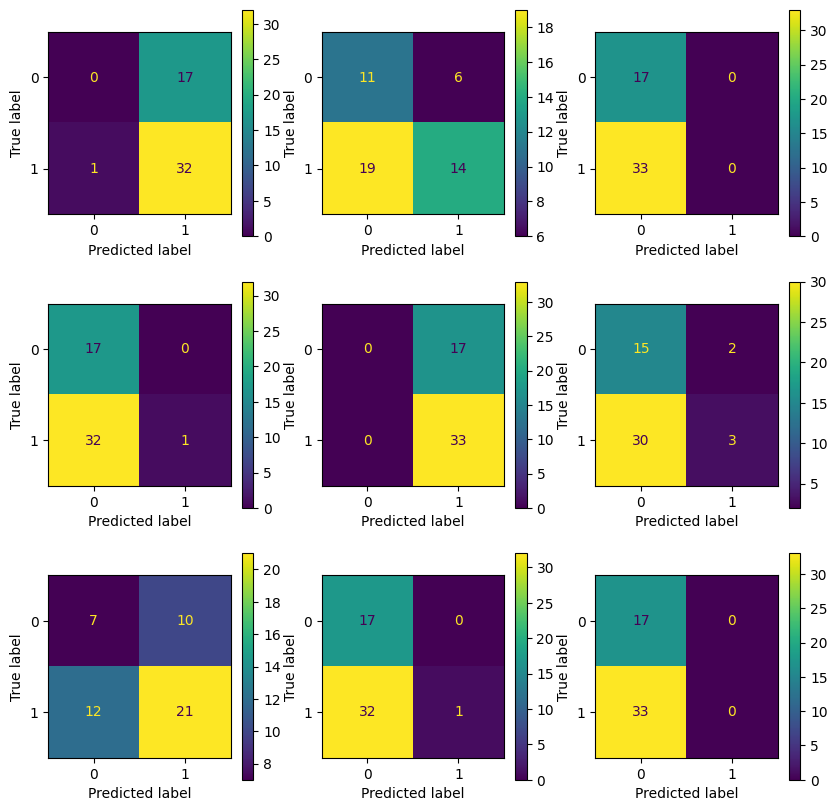

In [114]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

for i in range(9):
    p = NaivePerceptron()
    predicted = p.predict(x_samples)
    df['predicted'] = predicted
    stats = confusion_matrix(y_samples, predicted)
    
    plot = ConfusionMatrixDisplay(confusion_matrix=stats)
    plot.plot(ax=ax[int(i/3)][i%3])
plt.show()

## Add training methods to the perceptron

To improve the perceptron, we want it to adjust its weights while going through training samples one by one. We need to add a learning rate to determine how fast we go with gradient descent.

To do gradient descent, we first calculate the difference between predicted and expected classification. This can only be 0, -1, or 1 and essentially means a direction rather than a magnitude. The magnitude is determined by x itself, tuned by the learning rate. 

To gain an intuition, suppose y=1 and prediction=0, this means the weighted sum is below the activation threshold. w_i needs to be bigger whenever x_i is positive and smaller whenever x_i is negative. So if we set the error term as y_true - y_pred, then we want to move towards the direction of this term.

In [245]:
class SmartPerceptron(NaivePerceptron):
    def __init__(self, learning_rate=0.1):
        self.learning_rate = learning_rate
        super().__init__()

    def fit(self, x, y, epochs, verbose=False):
        for i in range(epochs):
            err = 0
            for x_i, y_i in zip(x, y):
                err += self.fit_single(x_i, y_i)
            if verbose:
                print(f"error for epoch {i+1}: {err}")

    def fit_single(self, x, y):
        pred = self.predict_single(x.tolist())
        err = y - pred
        x_with_bias = np.array(x.tolist() + [1])
        self.w += self.learning_rate * err * x_with_bias
        return err

Check the error at each epoch. We expect it to roughly reduce at each epoch.

In [263]:
p = SmartPerceptron()
p.fit(x_samples, y_samples, 10, verbose=True)
pred = p.predict(x_samples)

error for epoch 1: 4
error for epoch 2: 2
error for epoch 3: 0
error for epoch 4: 0
error for epoch 5: 1
error for epoch 6: 0
error for epoch 7: 1
error for epoch 8: 1
error for epoch 9: 1
error for epoch 10: 1


Now check how the smart perceptron performs. For each perceptron, we look at the final results after trianing for 20 epoches.

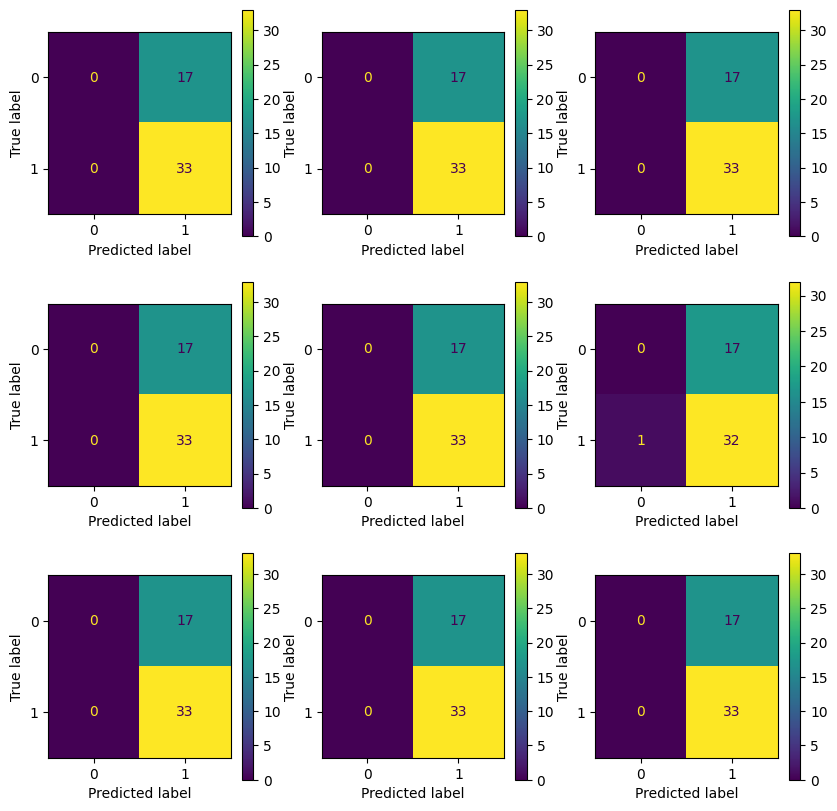

In [264]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

for i in range(9):
    p = SmartPerceptron()
    p.fit(x_samples, y_samples, 5)
    predicted = p.predict(x_samples)
    df['predicted'] = predicted
    stats = confusion_matrix(y_samples, predicted)
    
    plot = ConfusionMatrixDisplay(confusion_matrix=stats)
    plot.plot(ax=ax[int(i/3)][i%3])
plt.show()

Interestingly, all converge to a naive approach of just calling every sample True! I believe this is due to the limitation of network size and the target function. If we simply predict True, then 66% of the time we are correct.

## Try a different set of samples

what if we artificially generate a set of samples that actually fit under the rules by the perceptron algorithm, based on w and activation function

In [279]:
x_samples_smart = np.random.randint(0, 10, size=(50, 2))
w = np.random.randn(3)

with_bias = np.c_[x_samples_smart, np.ones((x_samples_smart.shape[0]))]
weighted_sum = np.matmul(with_bias, w.transpose())

def activate(s):
    return 1 if s > 0 else 0

y_samples_smart = [activate(s) for s in weighted_sum]

As before, see what happens with untrained perceptron. It does pretty bad!

/home/yli/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/yli/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


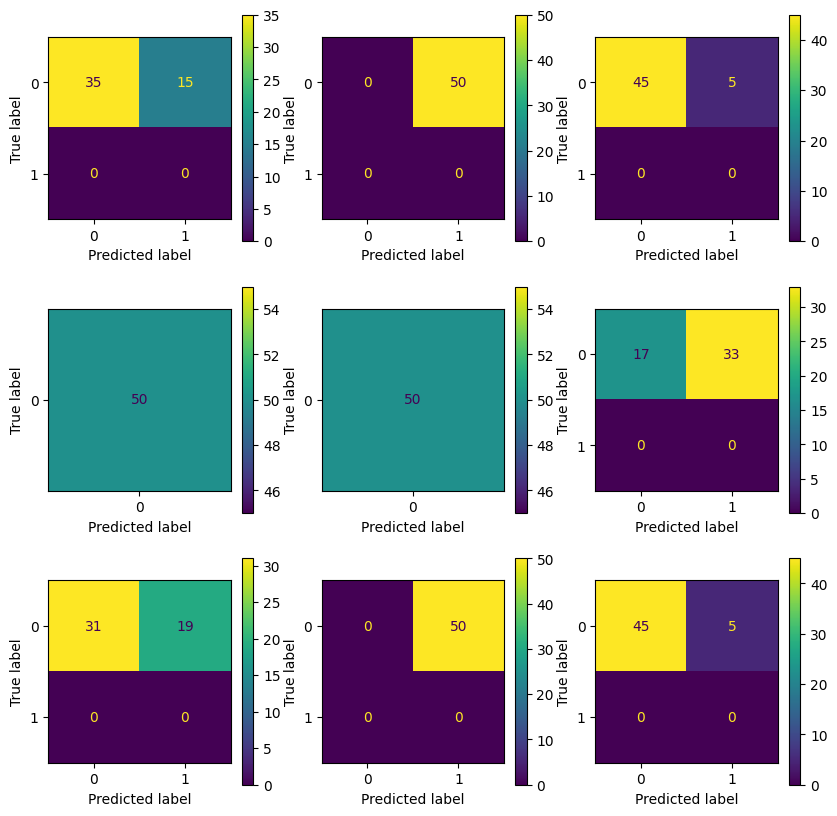

In [282]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

for i in range(9):
    p = NaivePerceptron()
    predicted = p.predict(x_samples_smart)
    df['predicted'] = predicted
    stats = confusion_matrix(y_samples_smart, predicted)
    plot = ConfusionMatrixDisplay(confusion_matrix=stats)
    plot.plot(ax=ax[int(i/3)][i%3])
plt.show()

With training, it does fairly well with 30 epochs.

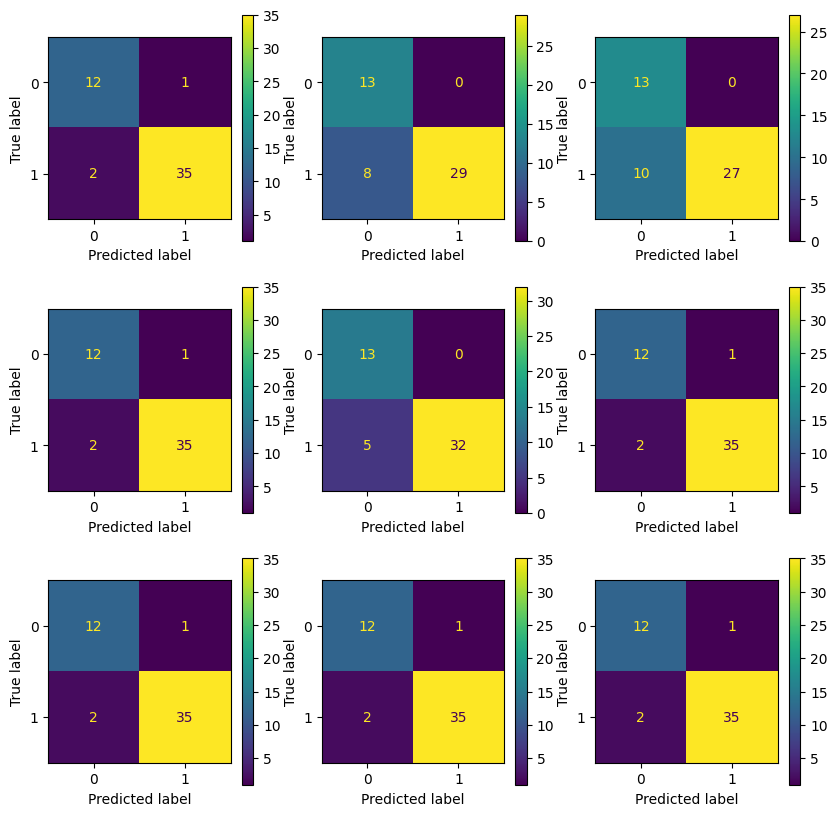

In [278]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

for i in range(9):
    p = SmartPerceptron()
    p.fit(x_samples_smart, y_samples_smart, 30)
    predicted = p.predict(x_samples_smart)
    df['predicted'] = predicted
    stats = confusion_matrix(y_samples_smart, predicted)
    
    plot = ConfusionMatrixDisplay(confusion_matrix=stats)
    plot.plot(ax=ax[int(i/3)][i%3])
plt.show()

This concludes perceptron, the foundational unit of neural network